<a href="https://colab.research.google.com/github/hoangxtr/form_detection/blob/master/vizualize_form_sep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!python -m pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html

clear_output()

In [ ]:
%cd /content/
!gdown --id 1I0_oQcyiKS9TRCNNGzHvNFsamnLLRxFB

!unzip /content/Annotated-20210812.zip
!rm /content/Annotated-20210812.zip

clear_output()

In [ ]:
!gdown --id 1-WeaSrUIlHW8Pj0woXwd719zILuabhIJ
!unzip 201-300.zip

clear_output()

In [ ]:
! git clone https://github.com/xingyizhou/CenterNet2
!gdown --id 1VpCSyUFoKB4UHYVftUxTa8c0PWLZ5DUF -O /content/Shipping_label_LVIS_R50_hybrid.yaml

%cd /content/CenterNet2/projects/CenterNet2/

Cloning into 'CenterNet2'...
remote: Enumerating objects: 11053, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 11053 (delta 65), reused 144 (delta 60), pack-reused 10888
Receiving objects: 100% (11053/11053), 4.62 MiB | 1.53 MiB/s, done.
Resolving deltas: 100% (7958/7958), done.
Downloading...
From: https://drive.google.com/uc?id=1VpCSyUFoKB4UHYVftUxTa8c0PWLZ5DUF
To: /content/Shipping_label_LVIS_R50_hybrid.yaml
100% 858/858 [00:00<00:00, 828kB/s]
/content/CenterNet2/projects/CenterNet2


In [ ]:
import atexit
import bisect
import multiprocessing as mp
from collections import deque
import cv2
import torch

import numpy as np
import matplotlib.pyplot as plt
import json

plt.rcParams["figure.figsize"] = (30,15)

from detectron2.data import MetadataCatalog
from detectron2.engine.defaults import DefaultPredictor

from detectron2.config import get_cfg
from centernet.config import add_centernet_config

In [ ]:
def centernet2_detect(predictor, image) :
    predictions = predictor(image)['instances']
    bboxes = predictions.pred_boxes.tensor.cpu().numpy()
    keypoints = predictions.pred_keypoints.cpu().numpy()
    # print('pred box ', bboxes)
    # print('pred score', predictions.scores.cpu().numpy())
    # print('pred keypoints', keypoints)
    detect_sl = []
    for box,keypoint in zip(bboxes,keypoints):
        # idx += 1
        x1,y1,x2,y2 = np.array(box, dtype=np.int32)
        if y1 >= y2 or x1 >= x2 :
            continue
        crop_image = image[y1:y2,x1:x2,:]
        skip_rectify = False
        for score_kp in keypoint[:,2]:
            if score_kp <= 0.4 :
                result_image = crop_image
                detect_sl.append(result_image)
                skip_rectify = True
                break
        if skip_rectify :
            continue
        tl, tr, bl, br = keypoint[:,:2] - np.array([x1,y1])
        height, width,_ = crop_image.shape
        all_kps = [tl, tr, bl, br]
        return_box = False
        for  i in range(len(all_kps) - 1):
            stop = False
            for j in range(i+1,len(all_kps)):
                p1 , p2 = all_kps[i], all_kps[j]
                distance = np.sqrt(((p1[0] - p2[0]) ** 2) + ((p1[1] - p2[1]) ** 2))
                if distance < 0.2 * min(width,height) :
                    stop = True
                    return_box = True
            if stop :
                break
        if return_box:
            detect_sl.append(crop_image)
            continue
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))
        dst = np.array([
            [0, 0],                         
            [maxWidth - 1, 0],            
            [maxWidth - 1, maxHeight - 1], 
            [0, maxHeight - 1]],         
            dtype = "float32"          
        )
       
        M = cv2.getPerspectiveTransform(np.array([tl, tr, br, bl], dtype = "float32" ), dst)
        result_image = cv2.warpPerspective(crop_image, M, (maxWidth, maxHeight))
        detect_sl.append(result_image)
    return detect_sl

In [ ]:
def setup_cfg(model_path, conf_thresh=0.3):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_centernet_config(cfg)
    cfg.merge_from_file(CONFIG_PATH)
    # cfg.merge_from_list(args.opts)
    cfg.MODEL.WEIGHTS = model_path
    # Set score_threshold for builtin models
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = conf_thresh
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = conf_thresh
    if cfg.MODEL.META_ARCHITECTURE in ['ProposalNetwork', 'CenterNetDetector']:
        cfg.MODEL.CENTERNET.INFERENCE_TH = conf_thresh
        cfg.MODEL.CENTERNET.NMS_TH = cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = conf_thresh
    cfg.freeze()
    return cfg

In [ ]:
def resize_keep_origin_ratio(img, width=1600, height=1120):

    # return img

    img = img.copy()
    h,w = img.shape[:2]
    img_ratio = h/w
    aspect_ratio = height/width
    if aspect_ratio > img_ratio:
        resized_width = width
        resized_height = int(resized_width * img_ratio)
    else:
        resized_height = height
        resized_width = int(resized_height / img_ratio)
    img = cv2.resize(img, (resized_width, resized_height), cv2.INTER_AREA)
    return img

In [ ]:
def process(predictor, img, sep_form=True):
  img = img.copy()
  predictions = predictor(img)
  predictions = predictions['instances'].to('cpu:0')
  all_forms = []
  
  for i in range(len(predictions)):
    bboxes = predictions[i].pred_boxes.tensor.cpu().numpy()
    keypoints = predictions[i].pred_keypoints.cpu().numpy()
    # print(keypoints)
    scores = predictions[i].scores.cpu().numpy()
    if sep_form:
      all_forms.append(crop_form(img, bboxes, keypoints))
    else:
      img = viz_instance(img, bboxes, keypoints, scores)
  if sep_form:
    return all_forms
  return img

In [ ]:
def viz_instance(img, bboxes, keypoints, scores):
  # print('______________________________________________________________________-')
  img = img.copy()
  for bbox, keypoint, score in zip(bboxes, keypoints, scores):
    x1,y1,x2,y2 = np.asarray(bbox, dtype=np.int32)
    # print((x1,y1,x2,y2))
    img = cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 4)
    point_color = [50,100,200]
    for i, point in enumerate(np.round(keypoint)):
      # point_color = (255,0,0) if point[2] == 1 else (0,0,255)
      if point[0] > img.shape[1] or point[0] < 0 or point[1] > img.shape[0] or point[0] < 0:
        print('Case nay sai ne')
      # print(f'i: {i}\npoint: {point}\n')
      img = cv2.circle(img, (point[0], point[1]), 20, COLOR_LIST[i], -1)
      img = cv2.putText(img, TEXT_LIST[i], (point[0], point[1]), cv2.FONT_HERSHEY_COMPLEX, 2, COLOR_LIST[i], 2)
    img = cv2.putText(img, "{:.2f}".format(score), (x1,y1), cv2.FONT_HERSHEY_COMPLEX, 3, (10,62,138), 3)
  return img

In [ ]:
def viz_form(form_list, index):
  bbox_img = form_list[index][0]
  rotate_img = form_list[index][1]

  fig, ax = plt.subplots(1, 2)
  fig.set_size_inches(20, 10)
  ax[0].imshow(bbox_img)
  ax[0].set_title('bbox result')
  ax[1].imshow(rotate_img)
  ax[1].set_title('rotated result')

In [ ]:
def crop_form(img, bboxes, keypoints):
  rets = []
  # print('start')
  for bbox, keypoint in zip(bboxes, keypoints):
    x1,y1,x2,y2 = np.asarray(bbox, dtype=np.int32)
    # print(f'{[x1,x2,y1,y2]}\n{keypoint}')
    # print('\n')
    crop_img = img[y1:y2, x1:x2, :].copy()
    w,h = crop_img.shape[:2]
    keypoint = np.round(keypoint)
    tl,tr,bl,br = keypoint[:, :2] - np.array([x1,y1]).reshape(1,2)
    width1 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    width2 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    max_width = int(max(width1, width2))

    height1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = int(max(height1, height2))

    dst = np.array([[0,0], [max_width -1, 0], [max_width-1, max_height-1], [0,max_height-1]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(np.array([tl, tr, br, bl], dtype='float32'), dst)
    ret_img = cv2.warpPerspective(crop_img.copy(), M, (max_width, max_height))

    for i, point in enumerate(np.asarray([tl,tr,bl,br], dtype=np.int32)):
      # point_color = (255,0,0) if point[2] == 1 else (0,0,255)
      crop_img = cv2.circle(crop_img, (point[0], point[1]), 20, COLOR_LIST[i], -1)
      crop_img = cv2.putText(crop_img, TEXT_LIST[i], (point[0], point[1]), cv2.FONT_HERSHEY_COMPLEX, 2, COLOR_LIST[i], 2)
    
    rets += [[crop_img, ret_img]]
  # print('end')
  return rets[0]



In [ ]:
!ls /content/drive/MyDrive/Create_Data_Vendor_forms

In [ ]:
# IMAGE_PATH = '/content/Annotated-20210812/Quang Tran (1-15)/1-15Photo Annotate/images/3.jpg'
IMAGE_PATH = '/content/201-300/255.jpg'
IMAGE_PATH = '/content/drive/MyDrive/Create_Data_Vendor_forms/15.jpg'
# HOANG_MODEL_PATH = "/content/drive/MyDrive/Copy of FormDetectionData/model/hoang_model_0019999.pth"
HOANG_MODEL_PATH = "/content/drive/MyDrive/Copy of FormDetectionData/300forms_save_folder/model_0046499.pth"
HOANG_MODEL_PATH = '/content/drive/MyDrive/Copy of FormDetectionData/new_300forms_save_folder/no_mask/model_0031499.pth'
LAM_MODEL_PATH = '/content/drive/MyDrive/Copy of FormDetectionData/model/model_0020999.pth'
CONFIG_PATH = '/content/Shipping_label_LVIS_R50_hybrid.yaml'
COLOR_LIST = [(255,255,0), (51,51,255), (255,51,153), (204,255,229)]
TEXT_LIST = ['TL', 'TR', 'BL', 'BR']

**Result**
- Form 250 true bbox, fail keypoint
- Nhìn chung, các form rotate < 180 degree đa phần đúng hết, > 180 degree thì hên xui =))

In [ ]:
lam_cfg = setup_cfg(LAM_MODEL_PATH, 0.5)
hoang_cfg = setup_cfg(HOANG_MODEL_PATH, 0.5)

lam_predictor = DefaultPredictor(lam_cfg)
hoang_predictor = DefaultPredictor(hoang_cfg)

Config '/content/Shipping_label_LVIS_R50_hybrid.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Config '/content/Shipping_label_LVIS_R50_hybrid.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


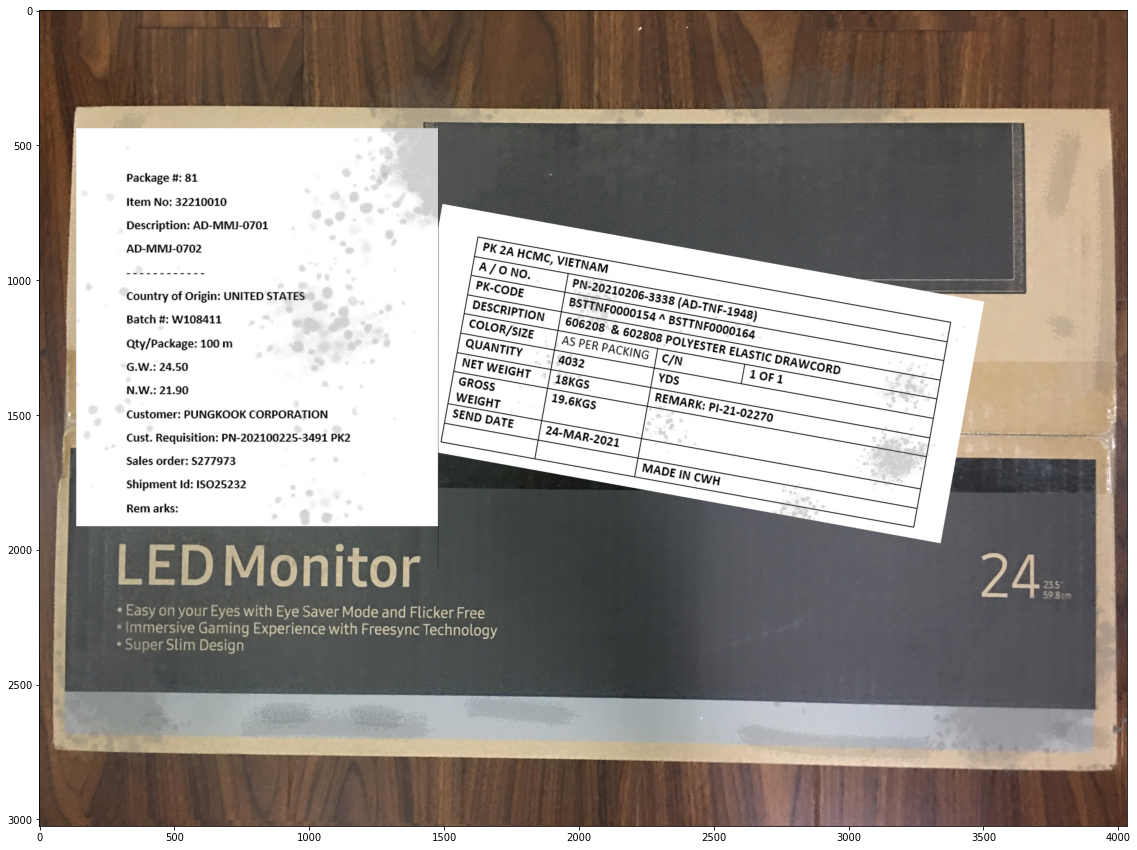

In [ ]:
img = cv2.imread(IMAGE_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = resize_keep_origin_ratio(img)
plt.imshow(img)

vizualize on image

In [ ]:
# print('lam process')
lam_ret_img = process(lam_predictor, img, False)
# print('hoang process')
hoang_ret_img = process(hoang_predictor, img, False)

Text(0.5, 1.0, 'Hoang result')

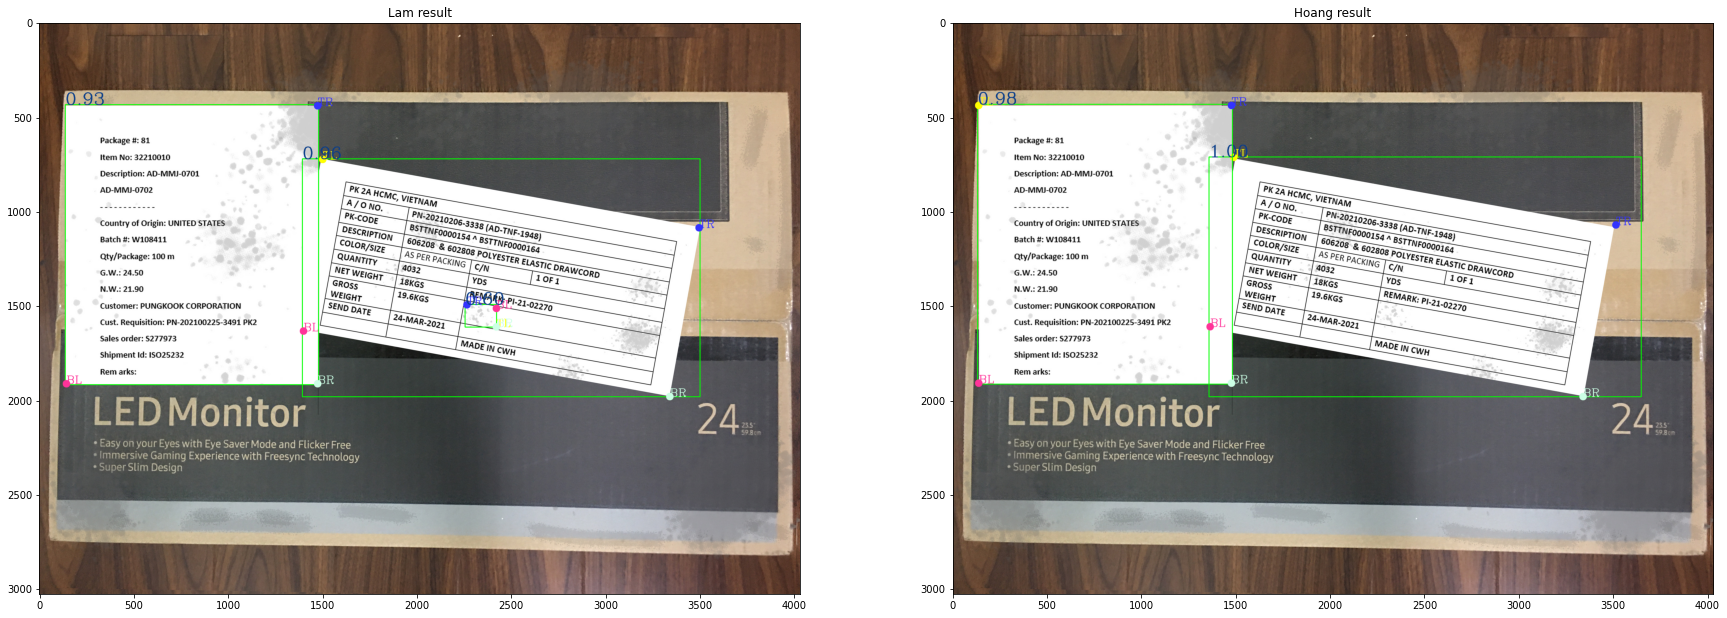

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(30, 20)
ax[0].imshow(lam_ret_img)
ax[0].set_title('Lam result')
ax[1].imshow(hoang_ret_img)
ax[1].set_title('Hoang result')

Cut form

In [ ]:
# print('lam process')
lam_ret_forms = process(lam_predictor, img, True)
print(f'Number form of old: {len(lam_ret_forms)}')
# print('hoang process')
hoang_ret_forms = process(hoang_predictor, img, True)
print(f'Number form of new: {len(hoang_ret_forms)}')


Number form of old: 3
Number form of new: 2


New model


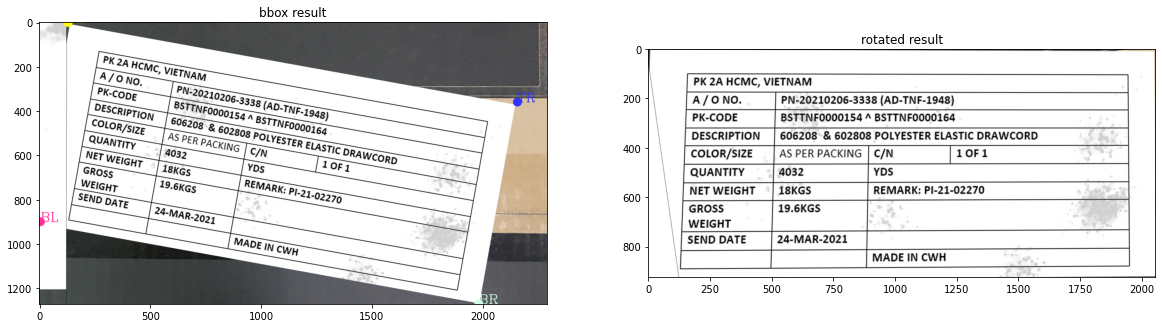

Old model


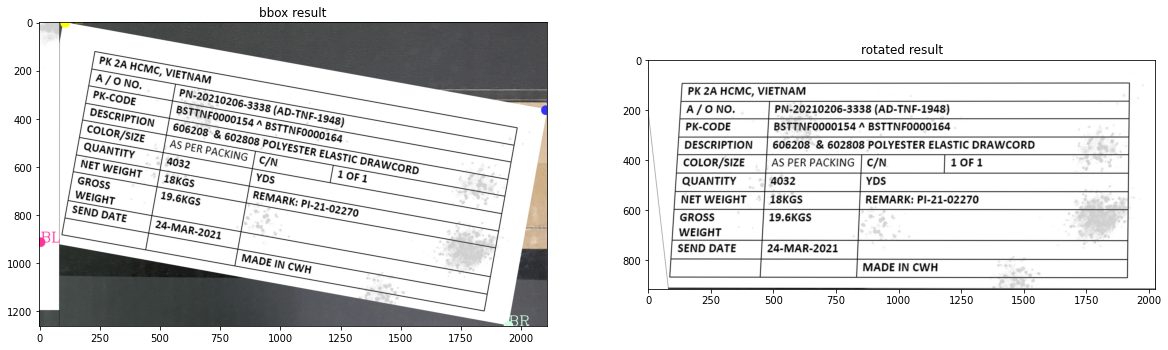

In [ ]:
temp_id = 0
try:
  print('New model')
  viz_form(hoang_ret_forms, temp_id)
  plt.show()
except:
  print('New model fail')

try:
  print('Old model')
  viz_form(lam_ret_forms, temp_id)
  plt.show()
except:
  print('Old model fail')

Addition

In [ ]:
def custom_resize(image, short_edge, long_edge) :
    h, w = image.shape[:2]
    scale = short_edge * 1.0 / min(h, w)
    if h < w:
        newh, neww = short_edge, scale * w
    else:
        newh, neww = scale * h, short_edge
    if max(newh, neww) > long_edge:
        scale = long_edge * 1.0 / max(newh, neww)
        newh = newh * scale
        neww = neww * scale
    neww = int(neww + 0.5)
    newh = int(newh + 0.5)
    return cv2.resize(image,(neww,newh), interpolation = cv2.INTER_LINEAR)

In [ ]:
len(centernet2_detect(lam_predictor, img))

2

In [ ]:
new_img = custom_resize(img.copy(), lam_cfg.INPUT.MIN_SIZE_TEST, lam_cfg.INPUT.MAX_SIZE_TEST)

In [ ]:
print(img.shape)
print(new_img.shape)

(1120, 1493, 3)
(800, 1066, 3)


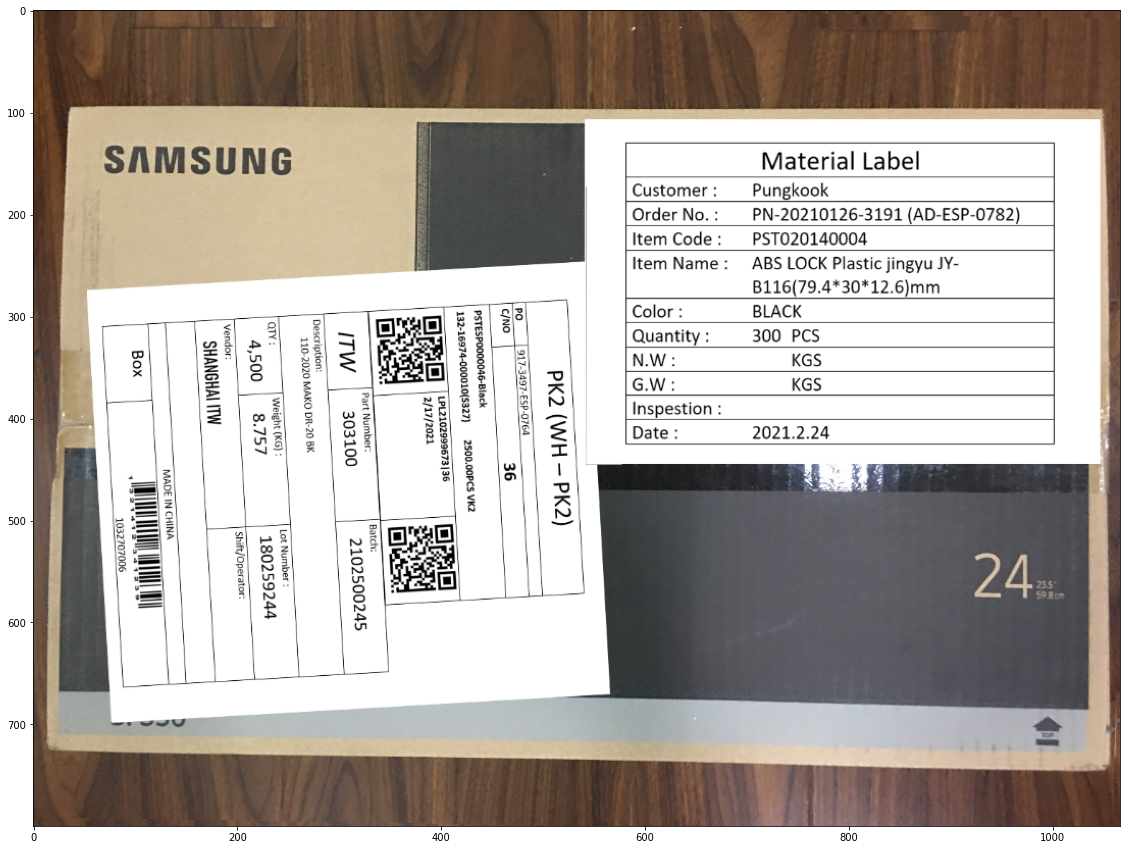

In [ ]:
plt.imshow(new_img)

In [ ]:
import detectron2.data.transforms as T
aug = T.ResizeShortestEdge(
            [lam_cfg.INPUT.MIN_SIZE_TEST, lam_cfg.INPUT.MIN_SIZE_TEST], lam_cfg.INPUT.MAX_SIZE_TEST
)

default_transform_img = aug.get_transform(img).apply_image(img)

In [ ]:
default_transform_img.shape

(800, 1066, 3)

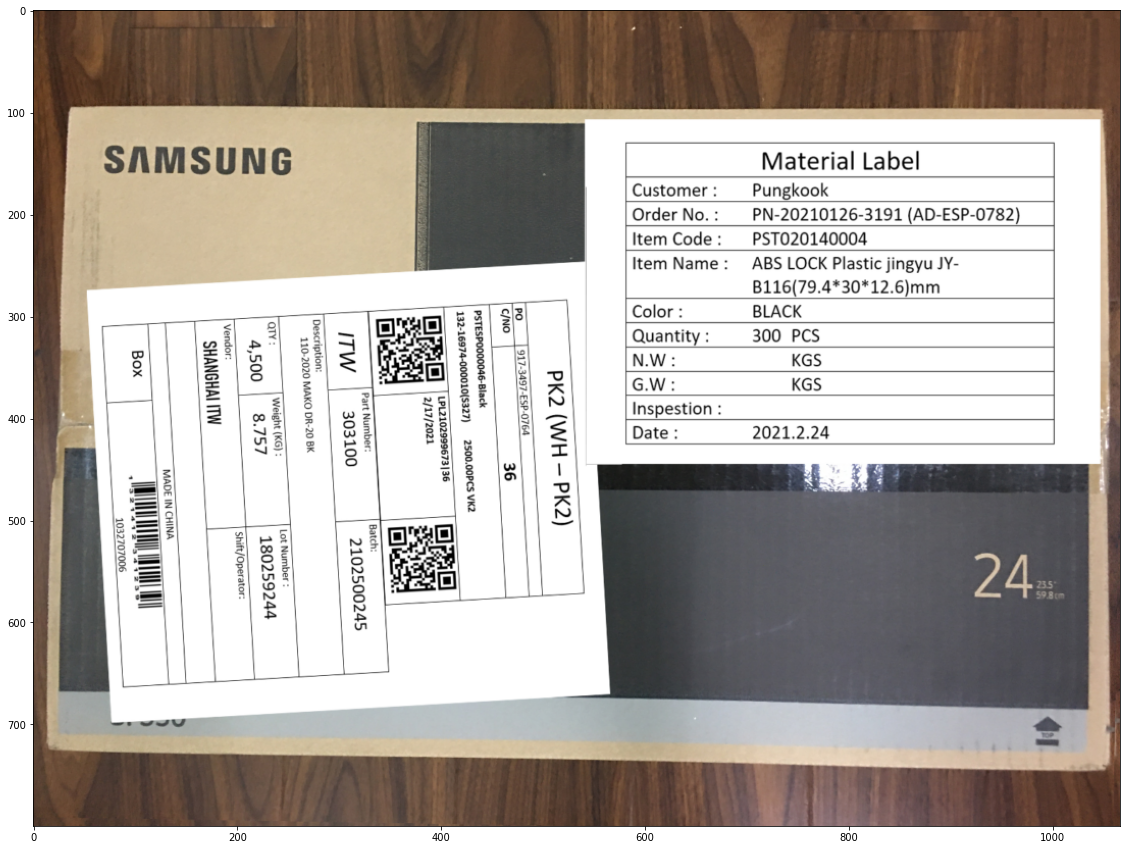

In [ ]:
plt.imshow(default_transform_img)

In [ ]:
ret = hoang_predictor(img)

In [ ]:
ret['instances'].get_fields().keys()

dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_masks', 'pred_keypoints', 'pred_keypoint_heatmaps'])

In [ ]:
temp_ret = ret['instances'].pred_masks.cpu().numpy()
temp_ret.shape

(5, 2644, 4032)

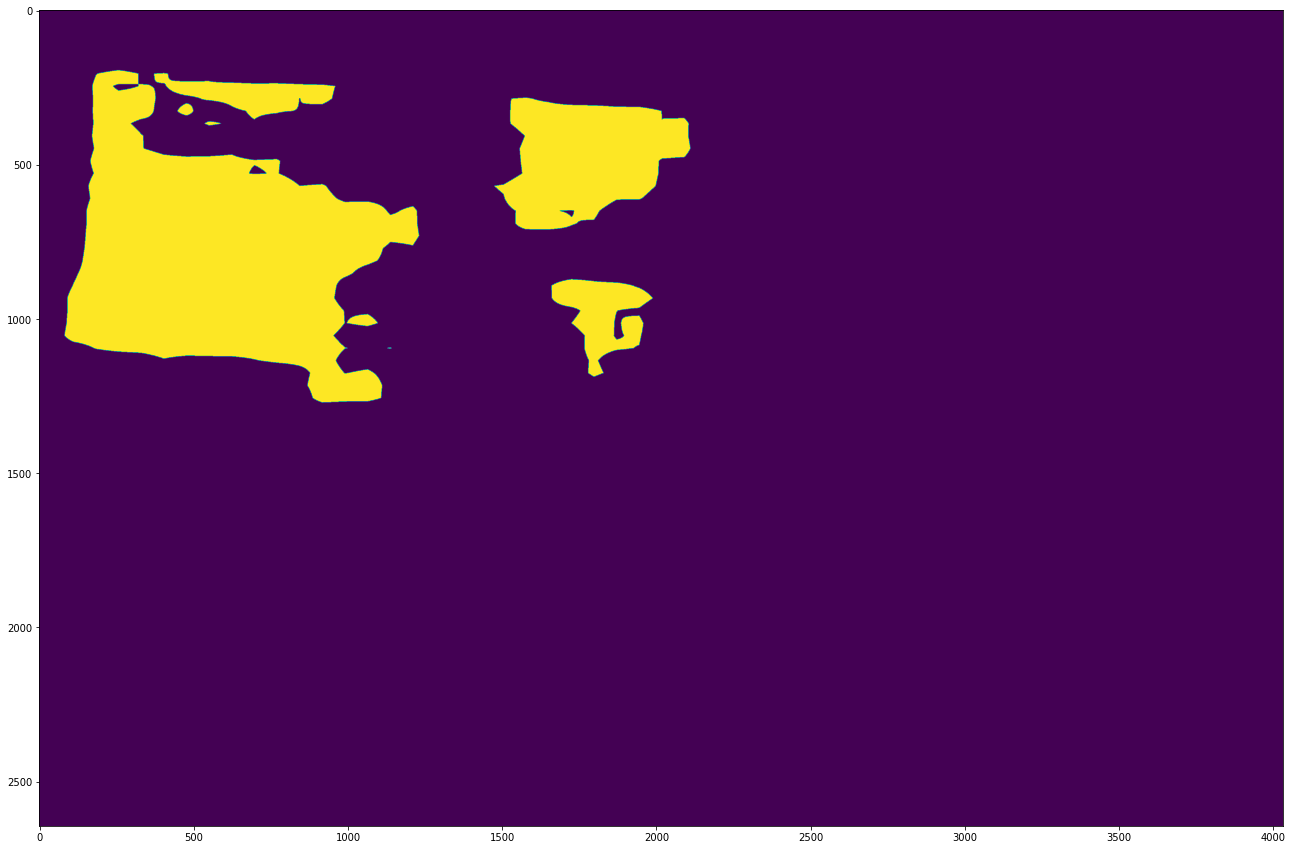

In [ ]:
plt.imshow(temp_ret[2])